In [1]:
import pandas as pd

In [2]:
from ipyfilechooser import FileChooser
from IPython.display import display
# Create a file chooser
fc = FileChooser('data/')
display(fc)

column_names = ['Setting', 'Timestamp', 'ADC']


# Button to load the selected file
def load_data(b):
    global df
    data_path = fc.selected
    if data_path:
        df = pd.read_csv(data_path, sep=',', header=None, names=column_names, usecols=column_names)
        display(df.head())

fc.register_callback(load_data)
# click on the output and use Alt+delete to clear and choose again

FileChooser(path='/Users/gavinlou/Developer/uom_explore/data', filename='', title='', show_hidden=False, selec…

,Setting,Timestamp,ADC
0,152,58550467,25984
1,155,58550468,25984
2,157,58550469,25981
3,160,58550470,25975
4,162,58550471,25968


In [4]:
import matplotlib.pyplot as plt

# Group the data by 'Setting'
grouped = df.groupby('Setting', as_index=False)  # Keep 'Setting' as a column, not as an index

# Normalize the timestamps in each group
def normalize_timestamps(group):
    group['Timestamp'] = group['Timestamp'] - group['Timestamp'].iloc[0]
    return group

# Apply the normalization function to each group
df_normalized = grouped.apply(normalize_timestamps).reset_index(drop=False)

# Group the normalized DataFrame again for plotting
grouped_normalized = df_normalized.groupby('Setting')

# grouped.size()


/var/folders/ty/_fq55jvd4533rn8vbpz3_kzc0000gn/T/ipykernel_19276/2895500631.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


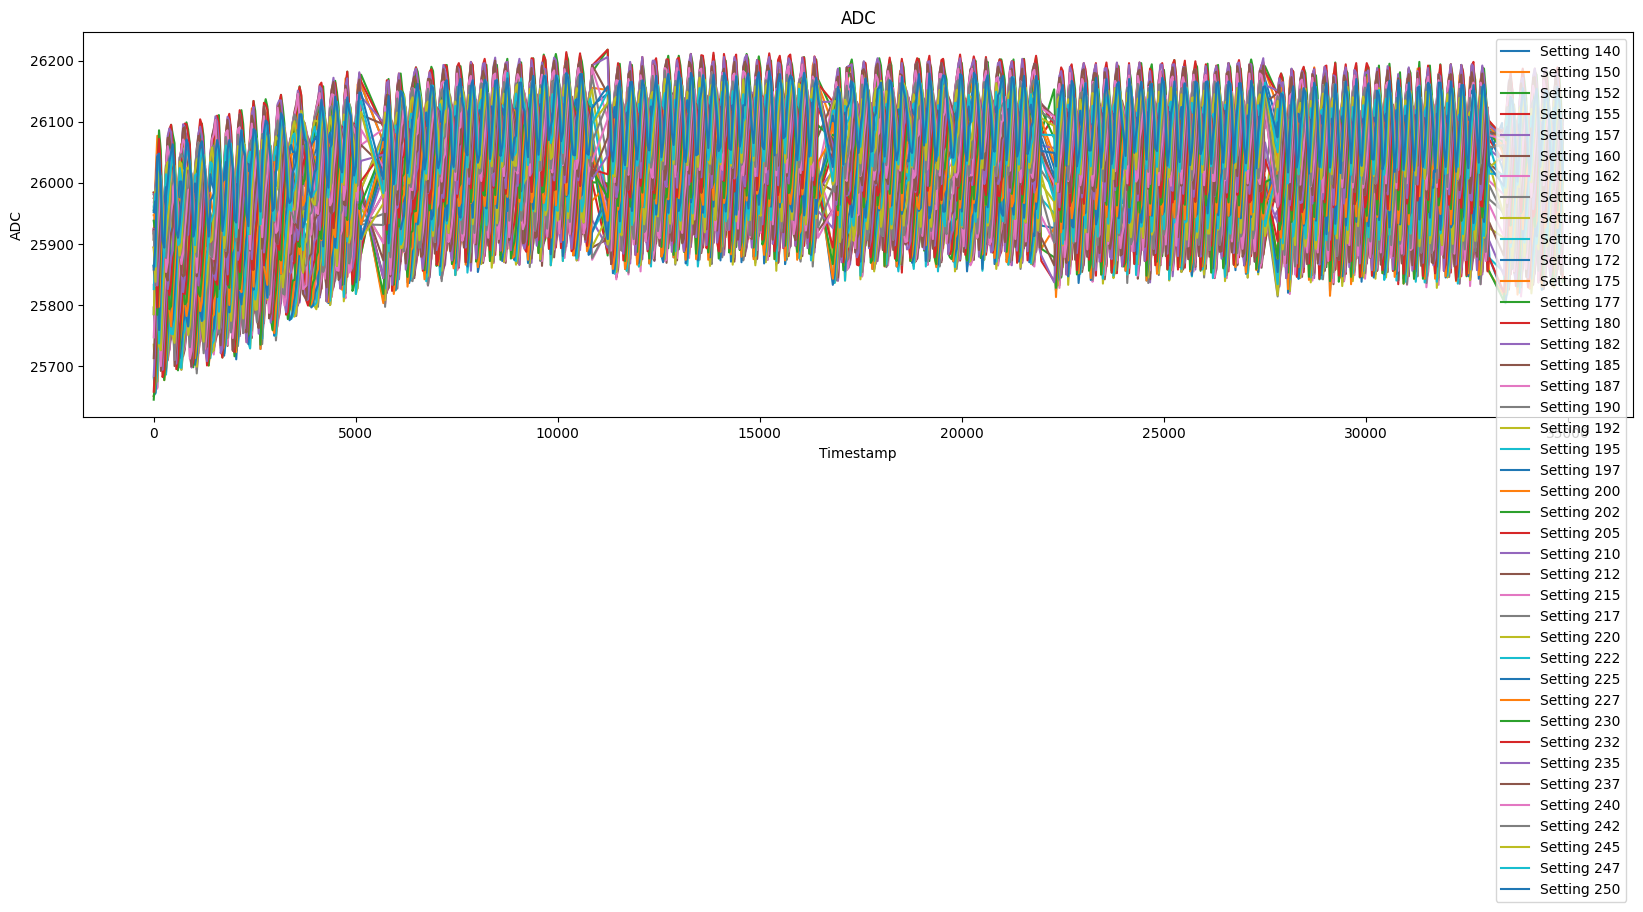

In [5]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(20, 5))

# Set the title for the subplot
ax.set_title('ADC')

# Plotting the ADC channel
for name, group in grouped_normalized:
    ax.plot(group['Timestamp'], group['ADC'], label=f'Setting {name}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('ADC')

# Add legend and adjust layout
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# use plotly to explore the data interactively
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume df_normalized is your DataFrame and is properly formatted

# Define the figure without subplots as we are plotting only one channel
fig = go.Figure()

# The channel to plot
channel = 'ADC'

# Plot the channel
for setting in df_normalized['Setting'].unique():
    # Filter the DataFrame for each setting
    df_filtered = df_normalized[df_normalized['Setting'] == setting]
    fig.add_trace(
        go.Scatter(
            x=df_filtered['Timestamp'],
            y=df_filtered[channel],
            mode='lines',
            name=f'Setting {setting}',
            # Optionally, you can uncomment and adjust the line color settings if needed
            # line=dict(color=colors[setting % len(colors)])  # Loop through colors cyclically
        )
    )

# Set titles and axes labels
fig.update_xaxes(title_text='Timestamp')
fig.update_yaxes(title_text=channel)
fig.update_layout(height=500, width=800, title_text=f'{channel} vs. Timestamp', showlegend=True)

# Display figure
fig.show()